# Clasificación de valoraciones de Google Play

__Regular Expression Operations__ 
    *<font color=gray>Este módulo proporciona operaciones de coincidencia de expresiones regulares similares a las que se encuentran en Perl. Tanto los patrones como las cadenas a buscar pueden ser cadenas Unicode (str), así como cadenas de 8 bits (bytes)</font>

In [1]:
# Regular expression operations
import re

_Natural Language Toolkit__
    *<font color=gray>NLTK es una plataforma líder para crear programas de Python para trabajar con datos de lenguaje humano. Proporciona interfaces fáciles de usar a más de 50 recursos corporales y léxicos como WordNet, junto con un conjunto de bibliotecas de procesamiento de texto para clasificación, tokenización, derivación, etiquetado, análisis y razonamiento semántico, envoltorios para bibliotecas NLP de potencia industrial, y un foro de discusión activo.)</font>

In [2]:
# Natural Language Toolkit
import nltk

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf

__imports__

    *Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) that a search engine has been programmed to ignore, both when indexing entries for searching and when retrieving them as the result of a search query. 
    * Dividir matrices o matrices en trenes aleatorios y subconjuntos de prueba Utilidad rápida que envuelve la validación de entrada y la siguiente (ShuffleSplit (). Split (X, y)) y la aplicación para ingresar datos en una sola llamada para dividir (y opcionalmente submuestrear) datos en una línea.

In [4]:
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

In [5]:
nltk.download('stopwords')

tf.__version__

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafra\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


'2.1.0'

In [6]:
data = pd.read_csv("../resources/googlePlay.csv")
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
2,10 Best Foods for You,NaN,NaN,NaN,NaN
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000


### Analisis del data set

In [7]:
data.shape # dimensiones

(64295, 5)

In [8]:
data.columns.values # nombres de las columnas

array(['App', 'Translated_Review', 'Sentiment', 'Sentiment_Polarity',
       'Sentiment_Subjectivity'], dtype=object)

In [9]:
data.describe()

,Sentiment_Polarity,Sentiment_Subjectivity
count,37432.000000,37432.000000
mean,0.182146,0.492704
std,0.351301,0.259949
min,-1.000000,0.000000
25%,0.000000,0.357143
50%,0.150000,0.514286
75%,0.400000,0.650000
max,1.000000,1.000000


In [10]:
data.dtypes

App                        object
Translated_Review          object
Sentiment                  object
Sentiment_Polarity        float64
Sentiment_Subjectivity    float64
dtype: object

In [11]:
pd.isnull(data['Sentiment']).ravel().sum()

26863

In [12]:
# Eliminaremos los valores nulos
data = data.dropna()
data.head()

,App,Translated_Review,Sentiment,Sentiment_Polarity,Sentiment_Subjectivity
0,10 Best Foods for You,I like eat delicious food. That's I'm cooking ...,Positive,1.00,0.533333
1,10 Best Foods for You,This help eating healthy exercise regular basis,Positive,0.25,0.288462
3,10 Best Foods for You,Works great especially going grocery store,Positive,0.40,0.875000
4,10 Best Foods for You,Best idea us,Positive,1.00,0.300000
5,10 Best Foods for You,Best way,Positive,1.00,0.300000


In [13]:
data.shape

(37427, 5)

Antes de proceder al procesamiento de los datos, se puede realizar una exploración previa de las frecuencias de los sentimientos mediante un diagrama de barras:

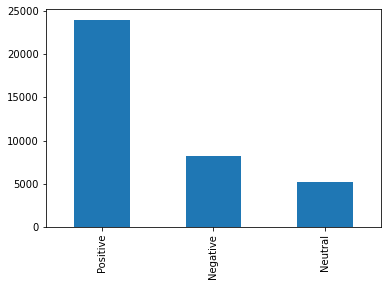

In [14]:
data['Sentiment'].value_counts().plot(kind='bar')

Ahora, a partir del mensaje se quiere predecir el tipo de sentimiento. Para ello, sacaremos esas dos columnas del dataframe:

In [15]:
data = data[['Translated_Review', 'Sentiment']]
data.head()

,Translated_Review,Sentiment
0,I like eat delicious food. That's I'm cooking ...,Positive
1,This help eating healthy exercise regular basis,Positive
3,Works great especially going grocery store,Positive
4,Best idea us,Positive
5,Best way,Positive


En principio, tenemos tres clases, de manera que podemos optar por estas dos vías:

    Considerar una clasificación binaria. Eliminaremos del dataframe aquellas muestras que pertenezcan a la categoría Neutral. Convertiremos el vector Sentiment en 0 o 1 según si es, respectivamente, negativo o positivo.
    Considerar la clasificación con los tres tipos. En este caso, deberemos formular una representación one-hot.



A partir de las columnas que nos interesan, se deben realizar los siguientes pasos para poder unificar todas las frases:

    Poner todas las letras en minúscula.
    Eliminar signos de puntuación, convirtiendo todas las palabras que se encontraban juntas en palabras por separado.
    Eliminar las stop words: Palabras cortas que carecen de significado por sí mismas, como las conjunciones o preposiciones.

Definimos una función que se encargará de esto, dada la frase sen por entrada:


In [16]:
def preprocess_text(sen):
    # Eliminar símbolos de puntuación y números
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    
    # Eliminar carácteres sueltos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    
    # Eliminar espacios excesivos
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # Convertir a minúscula
    sentence = sentence.lower()
    
    # Eliminar las stopwords
    words = sentence.split()
    filtered_words = [word for word in words if word not in stopwords.words('english')]
    
    return ' '.join(filtered_words)

En la función anterior se está haciendo referencia a la librería re, que viene cargada por defecto en Python. Es una librería dedicada para el tratamiento de expresiones regulares. Por consiguiente, tendremos que aplicar la función anterior a cada elemento de la columna Translated_Review del dataframe.

In [17]:
# tardó algodon
data['Translated_Review'] = data['Translated_Review'].apply(lambda sen: preprocess_text(sen))

# Representación vectorial del texto

En esta sección se tendrá por objetivo convertir una cadena de texto en un vector, para que pueda ser tratado por la red neuronal. En primer lugar, ara poder generar los conjuntos de entrenamiento y validación, separaremos el dataframe en dos variables independientes para poder tratarlas por separado:

In [18]:
def determine_class(label):
    if label == 'Positive':
        return 0
    if label == 'Neutral':
        return 1
    if label == 'Negative':
        return 2
    
    
# Poner la variable a True si se quieren eliminar los comentarios neutrales.
# En caso contrario, los neutrales se convertirán a negativos
REMOVE_NEUTRAL = False

# Poner la variable a True (siempre que la anterior valga False) para considerar
# las clases 'Negative' y 'Neutral' iguales.
MERGE_NEGATIVE_NEUTRAL = False
    
if REMOVE_NEUTRAL:
    indx_names = data[data['Sentiment'] == 'Neutral'].index
    data.drop(indx_names, inplace = True)
        
    y = data['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
    #y = tf.one_hot(y, 2)
        
else:
    if MERGE_NEGATIVE_NEUTRAL:
        y = data['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0).to_numpy()
        #y = tf.one_hot(y, 2)
    else: 
        y = data['Sentiment'].apply(lambda x: determine_class(x)).to_numpy()
        #y = tf.one_hot(y, 3)

X = data['Translated_Review']
y = y.astype(np.uint8)
    

In [19]:
import matplotlib.pyplot as plt

[]

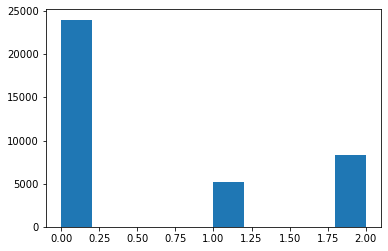

In [20]:
plt.hist(y)
plt.plot()

A partir de la librería sklearn podemos separar en dos conjuntos disjuntos, conteniendo el 80% de las muestras para el conjunto de entrenamiento y lo restantepara el de validación.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

El siguiente paso es determinar el número máximo de palabras que se usarán (es decir, las n primeras palabras más frecuentes) y la longitud máxima de cada vector.

In [30]:
# Esta clase permite vectorizar un corpus de texto, convirtiendo cada texto en una secuencia de enteros 
# (cada entero es el índice de una ficha en un diccionario) o en un vector donde el coeficiente de cada ficha 
# podría ser binario, en función del recuento de palabras , basado en tf-idf ...
from keras.preprocessing.text import Tokenizer

In [31]:
NUMBER_OF_WORDS = 20000
MAX_LEN = 100

# num_words: the maximum number of words to keep, based on word frequency. Only the most common `num_words-1` words will be kept.
tokenizer = Tokenizer(num_words = NUMBER_OF_WORDS)

# Actualiza vocabulario interno basado en una lista de secuencias.
tokenizer.fit_on_texts(X_train)

# Transforms each text in texts to a sequence of integers.
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Después, para aquellas frases que tengan palabras que no sean de las más frecuentes, se realiza la técnica de padding rellenando con ceros aquellas palabras que no sean tan frecuentes y no aparecen.

In [46]:
# Clase de utilidad para generar lotes de datos temporales. 
from keras.preprocessing.sequence import pad_sequences

# Pads secuencias a la misma longitud.
# padding: String, 'pre' or 'post': pad either before or after each sequence.
# maxlen: Int, maximum length of all sequences.
X_train = pad_sequences(X_train, padding='post', maxlen=MAX_LEN)
X_test = pad_sequences(X_test, padding='post', maxlen=MAX_LEN)

# Generar el modelo de Red Neuronal Recurrente

In [39]:
VOCABULARY_SIZE = NUMBER_OF_WORDS
EMBEDDING_SIZE = 128

In [41]:
# Crear el modelo secuencial
model = tf.keras.Sequential()

# Primera capa (Embedding convierte los textos en un vector de palabras)
model.add(tf.keras.layers.Embedding(VOCABULARY_SIZE, EMBEDDING_SIZE, input_shape =(X_train.shape[1],)))

# Capa Loss Short-Term Memory (recurrencia sobre las neuronas mismas)
model.add(tf.keras.layers.LSTM(units=128, activation='tanh'))

# Capa completamente conectada (en units se debe especificar cuantas clases tenemos)
model.add(tf.keras.layers.Dense(units=np.unique(y_train).shape[0], activation='sigmoid'))

# Compilacion del modelo
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['sparse_categorical_accuracy'])


In [47]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 3)                 387       
Total params: 2,691,971
Trainable params: 2,691,971
Non-trainable params: 0
_________________________________________________________________


In [48]:
model.fit(X_train, y_train, epochs = 3, batch_size = 128)

Train on 29941 samples
Epoch 1/3
29941/29941 [==============================] - 101s 3ms/sample - loss: 0.8968 - sparse_categorical_accuracy: 0.6397
Epoch 2/3
29941/29941 [==============================] - 94s 3ms/sample - loss: 0.8923 - sparse_categorical_accuracy: 0.6417
Epoch 3/3
29941/29941 [==============================] - 94s 3ms/sample - loss: 0.8922 - sparse_categorical_accuracy: 0.6417


In [49]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy : {}".format(test_accuracy))

7486/7486 [==============================] - 14s 2ms/sample - loss: 0.8965 - sparse_categorical_accuracy: 0.6391
Test Accuracy : 0.6390596032142639
